![title](MF_main.png "Изображение взято с ресурса https://kod.ru/megafon-cashback-jun-2019/")

Телекоммуникационные компании сейчас существуют не только за счет базовых услуг по предоставлению связи, наподобие обычных звонков и СМС, а уже давно расширяют арсенал возможностей:
* во-первых, для создания клиентской базы, которая будет меньше нуждаться в сторонних решениях (больше пользоваться киносервисом `START` вместо `Кинопоиска` и т.д.)
* во-вторых, для поиска новых путей получения прибыли и сфер влияния.

Именно поэтому важно привлекать новых клиентов к наилучшим предложениям (а также старых уже проверенных абонентов к новым решениям), но делать это необходимо не безраборно, а с максимальной выгодой для компании. Для решения этой проблемы ниже будет рассмотрен алгоритм предложения различных услуг клиентам "Мегафона" в различные временные периоды.

-----

*P.S. Обезличенные исходные данные получены от самих представителей компании, не представляется возможным восстановить какие-либо транзакции и персональные данные на из основе.*

----

Стандартыне процедуры подключения библиотек и загрузок датасетов:

In [22]:
import pandas as pd
import numpy as np
from dask import dataframe as dd
from pathlib import Path
import datetime
from datetime import datetime as dt

from sklearn.linear_model import RidgeClassifierCV, LogisticRegressionCV, LogisticRegression
from sklearn.metrics import f1_score, precision_score, recall_score, precision_recall_curve

from catboost import CatBoostClassifier

from matplotlib import pyplot as plt

import dill

import warnings
warnings.filterwarnings("ignore")

In [3]:
DATA_PATH = Path('Материалы')
FEATS_PATH = DATA_PATH / 'features.csv'

dd_df = dd.read_csv(FEATS_PATH / 'features.csv', sep='\t',)

test_df = pd.read_csv(DATA_PATH / 'data_test.csv', parse_dates=['buy_time'])
train_df = pd.read_csv(DATA_PATH / 'data_train.csv')

### Mini-EDA

In [3]:
test_df.head()

,Unnamed: 0,id,vas_id,buy_time
0,0,3130519,2.0,1548018000
1,1,2000860,4.0,1548018000
2,2,1099444,2.0,1546808400
3,3,1343255,5.0,1547413200
4,4,1277040,2.0,1546808400


In [4]:
dd_df.head()

,Unnamed: 0,id,buy_time,0,1,2,3,4,5,6,...,243,244,245,246,247,248,249,250,251,252
0,0,2013026,1531688400,18.910029,46.980888,4.969214,-1.386798,3.791754,-14.01179,-16.08618,...,-977.373846,-613.770792,-25.996269,-37.630448,-301.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
1,1,2014722,1539550800,36.690029,152.400888,448.069214,563.833202,463.841754,568.99821,-16.08618,...,-891.373846,-544.770792,-20.996269,48.369552,80.252276,-13.832889,-0.694428,-1.175933,-0.45614,0.0
2,2,2015199,1545598800,-67.019971,157.050888,-63.180786,178.103202,-68.598246,156.99821,3.51382,...,-977.373846,-613.770792,-12.996269,-37.630448,10829.252276,-25.832889,-0.694428,-12.175933,-0.45614,0.0
3,3,2021765,1534107600,7.010029,150.200888,-6.930786,216.213202,76.621754,351.84821,-16.08618,...,-973.373846,-613.770792,-23.996269,-37.630448,-205.747724,-24.832889,-0.694428,-11.175933,-0.45614,1.0
4,4,2027465,1533502800,-90.439971,134.220888,-104.380786,153.643202,-109.798246,132.53821,-16.08618,...,1643.626154,2007.229208,206.003731,-21.630448,6667.252276,92.167111,-0.694428,49.824067,47.54386,0.0


Как видно, исходные списки предложений о подключениях содержат только `id`абонента, VAS услуги и времени в формате **timestamp[s]**, в таком же формате находится и время в таблице признаков. Переведем их в более привычный **datetime** (также столбцы `Unnamed: 0` во всех выгрузках играют роль индекса и неинформативны, их можно в дальнейшем удалить):

In [8]:
%%time
test_df['buy_time'] = pd.to_datetime(test_df['buy_time'], unit='s')
train_df['buy_time'] = pd.to_datetime(train_df['buy_time'], unit='s')

dtime = dd_df.buy_time
dd_df['buy_time'] = dtime.map_partitions(pd.to_datetime, unit='s')

Wall time: 55 ms


In [6]:
test_df.head()

,Unnamed: 0,id,vas_id,buy_time
0,0,3130519,2.0,2019-01-20 21:00:00
1,1,2000860,4.0,2019-01-20 21:00:00
2,2,1099444,2.0,2019-01-06 21:00:00
3,3,1343255,5.0,2019-01-13 21:00:00
4,4,1277040,2.0,2019-01-06 21:00:00


Можно заметить, что первые значения имеют одинаковое время, но разную дату. Это наталкивает на мысль о том, что в выгрузках данные с достаточно крупными агрегациями - раз в день -, что будет достаточно сильно ограничивать дальнейшую аналитику. Если по всей выборке время будет одинаковым, то гипотезу точно можно будет считать верной:

In [26]:
pd.to_datetime(train_df['buy_time'], unit='s').dt.hour.unique()

array([21], dtype=int64)

In [28]:
dtime = dd_df.buy_time
dtime.map_partitions(pd.to_datetime, unit='s').dt.hour.unique().compute()

0    21
Name: buy_time, dtype: int64

Действительно, агрегация данных на текущий момент как минимум суточная (далее проверим на более крупную). Исходя из этого возникает ряд проблем:
* нельзя рассматривать отдельно случаи подключения абонентов в разное время суток;
* нельзя однозначно сказать, конкретное измерение относилось к текущим суткам или следуюшим из-за того, что ЧНН активности пользователей часто близок к вечерним часам. Наиболее удачное решение было бы сместить время примерно к 3-4 часам ночи - наименьшей активности абонентов.

Выведем список всех значений дат, т.к. агрегация минимум дневная и датасет содержит данные за 4 месяца, то строк не должно быть много:

In [30]:
np.sort(pd.to_datetime(train_df['buy_time'], unit='s').unique())

array(['2018-07-08T21:00:00.000000000', '2018-07-15T21:00:00.000000000',
       '2018-07-22T21:00:00.000000000', '2018-07-29T21:00:00.000000000',
       '2018-08-05T21:00:00.000000000', '2018-08-12T21:00:00.000000000',
       '2018-08-19T21:00:00.000000000', '2018-08-26T21:00:00.000000000',
       '2018-09-02T21:00:00.000000000', '2018-09-09T21:00:00.000000000',
       '2018-09-16T21:00:00.000000000', '2018-09-23T21:00:00.000000000',
       '2018-09-30T21:00:00.000000000', '2018-10-07T21:00:00.000000000',
       '2018-10-14T21:00:00.000000000', '2018-10-21T21:00:00.000000000',
       '2018-10-28T21:00:00.000000000', '2018-11-04T21:00:00.000000000',
       '2018-11-11T21:00:00.000000000', '2018-11-18T21:00:00.000000000',
       '2018-11-25T21:00:00.000000000', '2018-12-02T21:00:00.000000000',
       '2018-12-09T21:00:00.000000000', '2018-12-16T21:00:00.000000000',
       '2018-12-23T21:00:00.000000000', '2018-12-30T21:00:00.000000000'],
      dtype='datetime64[ns]')

In [31]:
np.sort(pd.to_datetime(test_df['buy_time'], unit='s').unique())

array(['2019-01-06T21:00:00.000000000', '2019-01-13T21:00:00.000000000',
       '2019-01-20T21:00:00.000000000'], dtype='datetime64[ns]')

In [28]:
dd_dt = dtime.map_partitions(pd.to_datetime, unit='s')
dd_dt = np.array(dd_dt.unique().compute())
np.sort(dd_dt)

array(['2018-07-08T21:00:00.000000000', '2018-07-15T21:00:00.000000000',
       '2018-07-22T21:00:00.000000000', '2018-07-29T21:00:00.000000000',
       '2018-08-05T21:00:00.000000000', '2018-08-12T21:00:00.000000000',
       '2018-08-19T21:00:00.000000000', '2018-08-26T21:00:00.000000000',
       '2018-09-02T21:00:00.000000000', '2018-09-09T21:00:00.000000000',
       '2018-09-16T21:00:00.000000000', '2018-09-23T21:00:00.000000000',
       '2018-09-30T21:00:00.000000000', '2018-10-07T21:00:00.000000000',
       '2018-10-14T21:00:00.000000000', '2018-10-21T21:00:00.000000000',
       '2018-10-28T21:00:00.000000000', '2018-11-04T21:00:00.000000000',
       '2018-11-11T21:00:00.000000000', '2018-11-18T21:00:00.000000000',
       '2018-11-25T21:00:00.000000000', '2018-12-02T21:00:00.000000000',
       '2018-12-09T21:00:00.000000000', '2018-12-16T21:00:00.000000000',
       '2018-12-23T21:00:00.000000000', '2018-12-30T21:00:00.000000000',
       '2019-01-06T21:00:00.000000000', '2019-01-13

Как оказалось, агрегация здесь даже недельная, что убирает возможность анализировать поведение пользователей и на выходных/праздничных днях, а также остается мало смысла рассматривать дату как важную фичу за такой короткий промежуток времени.

А также стоит заметить, что на `test` датасете имеем дело с неделей в начале года, что очень сильно может влиять на конечные результаты предсказания. Было бы крайне хорошо иметь прошлогодние данные за этот же промежуток.

----

Оценим полезность наших дат, можно ли строить историю для каждого пользователя и т.д.:

In [52]:
%%time
id_cnt = dd_df.groupby('id')['id'].count().compute()
id_cnt[id_cnt > 1].sort_values()

Wall time: 3min 26s


id
1318       2
6971       2
7637       2
9264       2
14368      2
          ..
3410244    2
3537081    2
3620266    2
4313991    2
2422554    2
Name: id, Length: 119977, dtype: int64

Т.к. для каждого абонента имеются максимум по 2 записи (в крайне малом объеме - около 3% от всех наблюдений), ни о какой историчности и сбору статистик по подключенным услугам у конкретного абонента нельзя говорить.

В таком случае можно попробовать посмотреть на общую динамику по каждой услуге и оценить ее:

In [203]:
group_df = pd.DataFrame(train_df.groupby(['vas_id', 'buy_time'])['target'].agg(['count', 'mean'])).reset_index()
group_df.vas_id = group_df.vas_id.astype('int')

timeline = np.sort(group_df.buy_time.dt.date.unique())

group_df.head()

,vas_id,buy_time,count,mean
0,1,2018-07-08 21:00:00,4427,0.014909
1,1,2018-07-15 21:00:00,7935,0.013359
2,1,2018-07-22 21:00:00,38507,0.012465
3,1,2018-07-29 21:00:00,6313,0.016316
4,1,2018-08-05 21:00:00,29643,0.009378


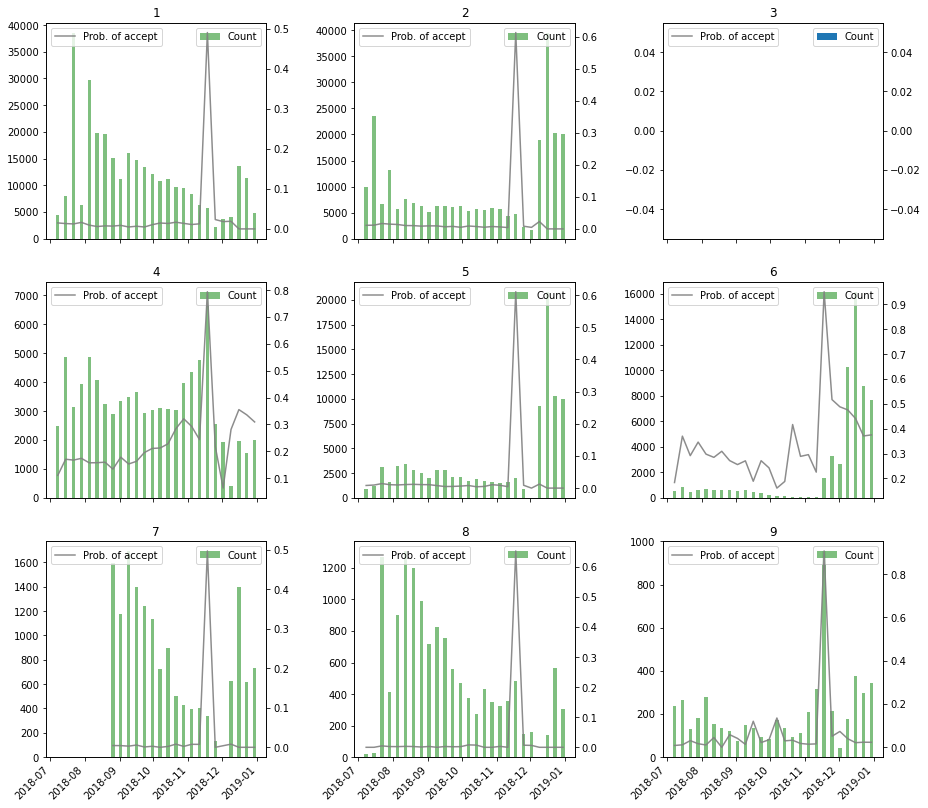

In [193]:
fig, axes = plt.subplots(3, 3, sharex=True)
plt.subplots_adjust(wspace=0.4)
fig.set_size_inches(15, 15)
fig.autofmt_xdate(rotation=45)
axes = axes.flatten()

for vas_id, ax in zip(range(1, 10), axes):    
    ox = group_df.loc[group_df.vas_id == vas_id, 'buy_time'].dt.date

    oy1 = group_df.loc[group_df.vas_id == vas_id, 'count']
    oy2 = group_df.loc[group_df.vas_id == vas_id, 'mean']
    
    ax2 = ax.twinx()
    
    x_ticks = ox
    ax.bar(ox, oy1, color='g', width=3, alpha=0.5, label='Count')
    ax2.plot(ox, oy2, 'b-', color='grey', alpha=0.9, label='Prob. of accept')
    ax.legend(loc=1)
    ax2.legend(loc=2)
    ax.set_title(vas_id)


In [218]:
group_df.sort_values('mean', ascending=False).reset_index().iloc[0]

index                       123
vas_id                        6
buy_time    2018-11-18 21:00:00
count                      1560
mean                   0.951282
Name: 0, dtype: object

Можно выделить несколько моментов:
* с декабря 2018 года активно начались рекламные кампании для услуг 2, 5, 6;
* виден всплеск как приглашений к подключению услуг, так и успешность подключения (вплоть до 95%) за неделю с 2018-11-18, что наводит на мысль о некорректных данных, можно будет считать этот период выбросом и дополнительно анализировать его отдельно при наличии дополнительных данных оператора;
* практически все услуги подключаются с крайне небольшим процентом, исключение составляются лишь 6, 4 и 9 (сильно позади)

In [204]:
train_df['target'].mean()

0.07236912510385943

In [107]:
train_df.groupby('vas_id')['target'].agg(['mean', 'count'])

,mean,count
vas_id,,
1.0,0.018261,310175
2.0,0.019226,249505
4.0,0.253801,85756
5.0,0.017984,94085
6.0,0.426829,57878
7.0,0.013802,15432
8.0,0.025993,13350
9.0,0.183480,5472


Подтвердились предположения о успехе подключений 6, 4 и 9 услуг, причем нумерация услуг скорее всего велась по снижения числа пользователей с ней (если это так, то можно сказать о том, что абонентов с успешно подключенной 4 услугой на тестовом датасете больше, чем с 5 :) )

-----

### Оптимизация датасета

Так как датасет достаточно объемный и текущая рабочая машина не позволяет достаточно быстро работать с ним полностью из оперативной памяти, предлагается убрать из него все лишнее и по возможности затем работать pandas датафреймом:

Уберем всех пользователей из `features`, которых нет в `train` и `test`:

In [59]:
ids = set(list(train_df.id.unique()) + list(test_df.id.unique()))
dd_df = dd_df[dd_df.id.isin(ids)]
dd_df.head()

,Unnamed: 0,id,buy_time,0,1,2,3,4,5,6,...,243,244,245,246,247,248,249,250,251,252
13,13,2046132,2018-08-19 21:00:00,300.820029,1599.480888,286.879214,1585.013202,281.461754,1563.90821,-16.08618,...,-977.373846,-613.770792,-25.996269,-35.630448,-295.747724,-17.832889,-0.694428,-4.175933,-0.45614,0.0
16,16,2050810,2018-10-28 21:00:00,-86.209971,91.820888,-84.480786,110.333202,-89.898246,89.22821,-16.08618,...,-977.373846,-613.770792,-23.996269,190.369552,-286.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
19,19,2070757,2018-10-28 21:00:00,-96.799971,-408.179112,-110.740786,-460.786798,-114.038246,-479.77179,-16.08618,...,-925.373846,-561.770792,-21.996269,-37.630448,-151.747724,-24.832889,0.305572,-12.175933,-0.45614,1.0
20,20,2071522,2018-12-16 21:00:00,-94.939971,-363.699112,-108.880786,-411.226798,-114.298246,-432.33179,-16.08618,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
22,22,2075318,2018-08-05 21:00:00,-75.639971,669.690888,-89.580786,732.343202,-94.998246,736.65821,-16.08618,...,-501.373846,-242.770792,-25.996269,-37.630448,-167.747724,-14.832889,2.305572,-4.175933,-0.45614,0.0


Далее уберем колонки, не несущие информации, а также те признаки, которые являются очень сильно коррелирующими между друг другом:

In [21]:
idx_column = 'Unnamed: 0'

train_df.drop(columns=idx_column, inplace=True)
test_df.drop(columns=idx_column, inplace=True)
dd_df.drop(columns=idx_column, inplace=True).compute()

In [65]:
%%time

corr_all = dd_df.corr().compute()
corr_all.loc[:,:] = np.tril(corr_all, k=-1) 

Wall time: 23min 18s


In [81]:
threshold = 0.90

already_in = set()
result = []
for col in corr_all:
    perfect_corr = corr_all[col][np.abs(corr_all[col]) >= threshold ].index.tolist()
    if perfect_corr and col not in already_in:
        already_in.update(set(perfect_corr))
        perfect_corr.append(col)
        result.append(perfect_corr)

In [82]:
result

[['2', '4', '0'],
 ['3', '1'],
 ['8', '11', '78', '79', '6'],
 ['71', '10'],
 ['72', '12'],
 ['14', '13'],
 ['35', '17'],
 ['104', '19'],
 ['24', '23'],
 ['33', '32'],
 ['116', '38'],
 ['112', '39'],
 ['113', '40'],
 ['123', '41'],
 ['124', '42'],
 ['45', '186', '43'],
 ['170', '44'],
 ['184', '46'],
 ['51', '151', '50'],
 ['147', '162', '54'],
 ['104', '76'],
 ['88', '83'],
 ['92', '91'],
 ['142', '101'],
 ['137', '135'],
 ['138', '136'],
 ['180', '179'],
 ['217', '209'],
 ['220', '216'],
 ['234', '230']]

*P.S. Здесь в каждом элементе списка отображен список названий признаков, имеющих корреляцию выше 0.9 (гибкий параметр)*

In [90]:
to_delete = ['Unnamed: 0']

for clmns in result:
    to_delete += clmns[1:]

Также удалим все признаки, имеющие константные значения в датасете:

In [112]:
feats_var = dd_df.var().compute()
feats_wo_info = list(feats_var[feats_var == 0].index)
feats_wo_info

['75', '81', '85', '139', '203']

In [114]:
dd_df.drop(columns=to_delete + feats_wo_info)

И далее считаем полученные данные как стаданртный `DataFrame` `pandas` для оптимизации быстродействия

In [122]:
dd_df.to_csv(FEATS_PATH / 'mod_features.csv', single_file=True)
dd_df = pd.read_csv(FEATS_PATH / 'mod_features.csv')

Объединим полученные датасет с исходными данными:

In [3]:
max_delta = train_df.buy_time.max() - dd_df.buy_time.min()

merged_train_df = pd.merge_asof(train_df.sort_values('buy_time'),
                                  dd_df.sort_values('buy_time'),
                                  by='id',
                                  on='buy_time',
                                  tolerance=max_delta,
                                  direction='backward'
                                 ).sort_values('id')
merged_train_df

,id,vas_id,buy_time,target,2,3,5,7,8,9,...,243,244,245,246,247,248,249,250,251,252
733315,2,2.0,2018-12-23 21:00:00,0.0,-110.740786,305.723202,284.61821,-65.076097,-6.78366,-30.006538,...,2300.626154,1492.229208,-21.996269,-35.630448,368.252276,11.167111,7.305572,-12.175933,-0.45614,0.0
178087,4,1.0,2018-08-05 21:00:00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
183447,15,1.0,2018-08-12 21:00:00,0.0,249.409214,140.873202,119.76821,317.953903,-6.78366,-30.006538,...,-381.373846,-613.770792,-24.996269,-31.630448,-212.747724,108.167111,-0.694428,107.824067,13.54386,1.0
500241,16,2.0,2018-10-28 21:00:00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
176943,29,1.0,2018-08-05 21:00:00,0.0,-36.590786,-248.926798,-270.03179,-65.076097,-6.78366,-30.006538,...,-847.373846,-509.770792,-25.996269,-37.630448,-233.747724,-10.832889,-0.694428,2.824067,-0.45614,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
793142,4362634,1.0,2018-12-30 21:00:00,0.0,-110.740786,-130.286798,-151.39179,-65.076097,-6.78366,-30.006538,...,-26.373846,-613.770792,118.003731,98.369552,-219.747724,151.167111,-0.694428,-12.175933,-0.45614,0.0
791222,4362640,2.0,2018-12-30 21:00:00,0.0,-105.190786,-107.776798,-128.88179,-65.076097,-6.78366,-30.006538,...,-974.373846,-610.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,1.0
791374,4362647,6.0,2018-12-30 21:00:00,0.0,363.839214,284.973202,263.86821,-65.076097,-6.78366,-30.006538,...,1351.626154,745.229208,-25.996269,-28.630448,26.252276,34.167111,-0.694428,47.824067,-0.45614,0.0
741257,4362684,5.0,2018-12-23 21:00:00,0.0,-27.720786,34.053202,46.84821,-65.076097,-6.78366,-30.006538,...,-598.373846,-283.770792,-22.996269,-34.630448,-208.747724,-10.832889,-0.694428,2.824067,-0.45614,1.0


In [4]:
null_cnt = merged_train_df.isnull().sum().max()
null_cnt, null_cnt / merged_train_df.shape[0]

(422929, 0.5085402205006174)

Как видно, почти половина пользователей не имеют признаков, а это может значить, что набор данных `features` не снимался в те периоды времени, в которые происходило изменение отсутствующей части пользователей, то есть или нужны более давние выгрузки, или необходимо изменить принцип сбора данных в `features` - а именно для недостающих данных снимать эти же признаки с текущего снимка базы данных (HLR, HSS, ...).

Так как часть выборки без данных достаточно весомая, то заменять их на средние, медианы и т.д. не вижу смысла. В данном случае лучше опираться на статистические показатели подключения пользователей, в этом случае у нас будет самый реальный усредненный процент успешного подключения.

------

Проверим долю отсутствующих значений в зависимости от даты:

In [5]:
gr_null_by_week_merged_train_df = merged_train_df[['buy_time']].copy()
gr_null_by_week_merged_train_df['isna'] = merged_train_df.isna().any(axis=1)
gr_null_by_week_merged_train_df = gr_null_by_week_merged_train_df.groupby('buy_time').mean('isna')

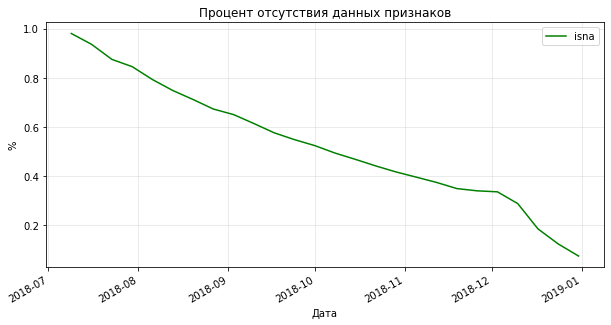

In [6]:
gr_null_by_week_merged_train_df.plot(color='g', figsize=(10, 5))
plt.grid(alpha=0.3)
plt.title('Процент отсутствия данных признаков')
plt.xlabel('Дата')
plt.ylabel('%')
plt.show()

Что здесь можно увидеть:
* с течением времени, начиная от 2018.07, растет процент пользователей, данные которых присутствуют в `features`, что выглядит полностью логично, т.к. имеющийся у нас набор данных в `features` фиксированный и присутствует с определенного числа, а вероятность абонента поменять профиль/быть зарегистрированным с ростом времени тоже растет, отсюда и повышается вероятность заполнения датасета с признаками; 
* видно нетипичное поведение полноты признаков с 2018.12. Сначала новых записей на протяжении пары недель было достаточно мало, но потом они начали появляться еще более активно, чем ранее. Возможно связано с тем, что был введен какой-либо новый тариф/проведена маркетинговая кампания/изменены предпочтения пользователей в связи с приближающимися праздниками. Для более точного ответа следует анализировать данные других операторов, данные год-к-году, а также смотреть историю корректировок акций и предложений компании для клиентов.

--------

Но сейчас данный график больше интересен тем, что научиться корректно использовать признаки на старых данных крайне сложно, поэтому отметку разделения на `train`/`test`, веротяно, следует сместить к сторону меньшего числа наблюдений на `test`, чем планировалось изначально (пару недель вместо месяца).

### Построение модели

Т.к. обучающий сет достаточно большой, можно разбить его на вализационную часть и на обучающую, а также обновить вероятноти подключения:

In [9]:
ref_date = '2018-12-23'
f_test_df = merged_train_df.loc[merged_train_df.buy_time > dt.strptime(ref_date, '%Y-%m-%d')].copy()
f_train_df = merged_train_df.loc[~(merged_train_df.buy_time > dt.strptime(ref_date, '%Y-%m-%d')) &\
                          (merged_train_df.buy_time != dt.strptime('2018-11-18 21', '%Y-%m-%d %H'))].copy()

In [8]:
stat_vas = f_train_df.groupby('vas_id')['target'].agg(['mean', 'count']).reset_index()[['vas_id', 'mean', 'count']]
stat_vas.vas_id = stat_vas.vas_id.astype('int')
stat_vas

,vas_id,mean,count
0,1,0.009858,288100
1,2,0.009211,204531
2,4,0.199510,75084
3,5,0.006720,71721
4,6,0.428643,39891
5,7,0.003418,13749
6,8,0.002584,11998
7,9,0.032008,3874


При учитывании спорного периода в неделю с 2018-11-25 значения получаются сильно разные по сравнению с тем, что имели ранее. Поэтому можно изменить полученные значения для 2, 5 и 6 услуг (где начался рост предложений в конце 2018 года), если бизнес будет не против этого, так как скорее на эти услуги сейчас направлен вектор развития и важно охватить как можно большую аудиторию.

In [9]:
stat_vas.loc[stat_vas.vas_id.isin([2, 5, 6]), 'mean'] = stat_vas.loc[stat_vas.vas_id.isin([2, 5, 6]), 'mean']**0.5
stat_vas

,vas_id,mean,count
0,1,0.009858,288100
1,2,0.095976,204531
2,4,0.199510,75084
3,5,0.081979,71721
4,6,0.654708,39891
5,7,0.003418,13749
6,8,0.002584,11998
7,9,0.032008,3874


Заметим, что минимальное число вхождений в группу чуть меньше 4 тысяч. Что, конечно, не очень много, но вполне достаточно, если будет принято решение обучать одну модель для решения о рекомендации услуги клиенту.

-----

Для бейзлайна модели будем использовать подход, основанный на статистике. Т.е. вероятность предложения определять из популярности подключения услуги (полученный датасет `stat_vas`), для оценки качества подхода реализуем `f1_calc`, которая будет принимать на вход название колонки, подставлять на пропущенные места популярность подключения услуги и показывать `Macro f1 score`:

In [10]:
results = f_test_df[['target']].copy()
results['vas_id'] = f_test_df['vas_id'].astype('int')
results = results.join(stat_vas[['vas_id', 'mean']].set_index('vas_id'), on='vas_id', rsuffix='_r')[['target', 'vas_id', 'mean']]
results.columns = ['target', 'vas_id', 'popularity']
# results['log_reg'] = np.nan
# results.loc[f_test_df_nnul.index, 'log_reg'] = f_test_df_nnul['pred']
results

,target,vas_id,popularity
733315,0.0,2,0.095976
806084,0.0,5,0.081979
746360,0.0,1,0.009858
805861,0.0,2,0.095976
746741,0.0,1,0.009858
...,...,...,...
793142,0.0,1,0.009858
791222,0.0,2,0.095976
791374,0.0,6,0.654708
741257,0.0,5,0.081979


In [5]:
def f1_calc(column, threshold=0.5, randomize_popular=True, seed=None, return_preds=False):
    assert column in results.columns, f'"{column}" must be in "results.columns"'
    
    if randomize_popular:
        np.random.seed(seed)
        koeff = np.random.normal(loc=1, scale=1, size=results.popularity.shape[0])
    else:
        koeff = 1
    popular = results.popularity * koeff
    
    if column == 'popularity':
        pred = popular
    else:
        tmp = results[[column]].copy()
        tmp['popularity'] = popular.copy()
        tmp.loc[tmp[column].isna(), column] = tmp['popularity']
        pred = tmp[column]
    
    if return_preds:
        return pred
    
    pred = np.where(pred > threshold, 1, 0)
    
    return f1_score(results.target, pred, average='macro')

def f1_draw(column, randomize_popular=True, seed=None, step=0.05):
    assert column in results.columns, f'"{column}" must be in "results.columns"'
    
    f1_dict = dict()
    ran = int(1 / step)
    for i in range(1, ran + 1):
        f1_dict[i / ran] = f1_calc(column, threshold=i / ran, randomize_popular=randomize_popular, seed=seed)
        
    max_elem = [[k, v] for k, v in sorted(f1_dict.items(), key=lambda item: item[1], reverse=True)][0]
    
    plt.grid(alpha=0.3)
    plt.plot(f1_dict.keys(), f1_dict.values(), color='green', label=column)
    plt.scatter(max_elem[0], max_elem[1], color='red', label=f'Threshold = {max_elem[0]}, F1 = {round(max_elem[1], 5)}')
    plt.xlabel('Threshold')
    plt.ylabel('f1 score')
    plt.title('Dependence of the F1 score on the selected threshold')
    plt.legend()
    plt.show()

    print(f'При пороге {max_elem[0]} значение F1 (macro) принимает максимальное значение в {round(max_elem[1], 5)}')

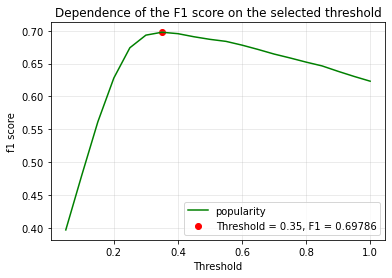

При пороге 0.35 значение F1 (macro) принимает максимальное значение в 0.69786


In [12]:
f1_draw('popularity', seed=10)

Как видно, даже если делать предложения только тем клиентам, которым предполагается изначально предложить только 6 услугу (а именно она имеет вероятность подключения выше 0.5), то даже в таком случае метрика выходит крайне достойная, но правильно ли это? Вряд ли. Поэтому в расчет по популярности добавлен случайный множитель из нормального распределения с мат. ожиданием в 1, что не будет изменять среднее значение, но добавит некоторую долю вариативности.

В общем случае описанное выше говорит лишь о том, что существует крайне различное поведение между случаями различных предложений услуг клиентам. Поэтому есть предположение, что модели, которые специальным образом не будут учитывать предлагаемую услугу будут отрабатывать хуже, чем модели, учитывающие конкретную услугу.

Построим модель лог. регрессии общую для всего датасета и затем отдельно 8 моделей для каждой из услуг и проверим это:

In [10]:
f_train_df_nnul = f_train_df.loc[~f_train_df.isna().any(axis=1)]
f_test_df_nnul = f_test_df.loc[~f_test_df.isna().any(axis=1)]

In [37]:
%%time
model = LogisticRegression(n_jobs=-1)
model.fit(f_train_df_nnul.drop(columns=['id', 'target', 'buy_time']), f_train_df_nnul.target)
pred = model.predict_proba(f_test_df_nnul.drop(columns=['id', 'target', 'buy_time']))

Wall time: 1min 6s


In [38]:
f_test_df_nnul = f_test_df_nnul.reset_index()
f_test_df_nnul['pred'] = pred[:, 1]
f_test_df_nnul.index = f_test_df_nnul['index']
f_test_df_nnul.drop(columns='index', inplace=True)

results['log_reg'] = np.nan
results.loc[f_test_df_nnul.index, 'log_reg'] = f_test_df_nnul['pred']
results.head()

,target,vas_id,popularity,log_reg
733315,0.0,2,0.095976,0.446514
806084,0.0,5,0.081979,0.504067
746360,0.0,1,0.009858,0.504077
805861,0.0,2,0.095976,0.542080
746741,0.0,1,0.009858,0.446677


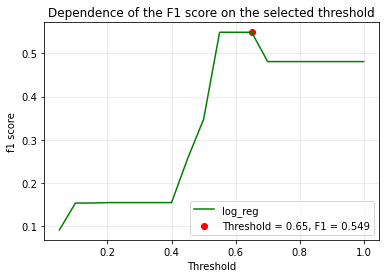

При пороге 0.65 значение F1 (macro) принимает максимальное значение в 0.549


In [46]:
f1_draw('log_reg', seed=10)

Как и ожидалось, модель, не учитывающая особенности каждой услуги, отработала не очень хорошо.

In [175]:
f_train_df_nnul = f_train_df.loc[~f_train_df.isna().any(axis=1)]
f_test_df_nnul = f_test_df.loc[~f_test_df.isna().any(axis=1)]
f_train_df_nnul.buy_time = f_train_df_nnul.buy_time.view(dtype='int64')
f_test_df_nnul.buy_time = f_test_df_nnul.buy_time.view(dtype='int64')
f_test_df_nnul['pred'] = np.nan

In [176]:
%%time
to_drop = ['id', 'target', 'vas_id', 'buy_time']
f_test_df_nnul['pred'] = np.nan

dedicated_model = dict()
for val in results.vas_id.value_counts().index:
    model = LogisticRegression(solver='saga')
    model.fit(f_train_df_nnul.loc[f_train_df_nnul.vas_id == val].drop(columns=to_drop),
              f_train_df_nnul.loc[f_train_df_nnul.vas_id == val, 'target']
              )
    dedicated_model[val] = model
    f_test_df_nnul.loc[f_test_df_nnul.vas_id == val, 'pred'] = \
        model.predict_proba(f_test_df_nnul.loc[f_test_df_nnul.vas_id == val].drop(
            columns=to_drop + ['pred']))[:, 1].copy()

Wall time: 1min 30s


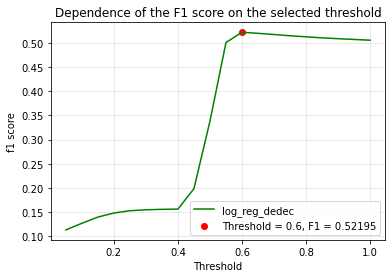

При пороге 0.6 значение F1 (macro) принимает максимальное значение в 0.52195


In [177]:
results['log_reg_dedec'] = np.nan
results.loc[f_test_df_nnul.index, 'log_reg_dedec'] = f_test_df_nnul['pred']

f1_draw('log_reg_dedec', seed=10)

In [187]:
%%time
to_drop = ['id', 'target']
f_test_df_nnul['pred'] = np.nan

model = CatBoostClassifier(verbose=False)
model.fit(f_train_df_nnul.drop(columns=to_drop), f_train_df_nnul.target)
pred = model.predict_proba(f_test_df_nnul.drop(columns=to_drop))

f_test_df_nnul = f_test_df_nnul.reset_index()
f_test_df_nnul['pred'] = pred[:, 1]
f_test_df_nnul.index = f_test_df_nnul['index']
f_test_df_nnul.drop(columns='index', inplace=True)

Wall time: 1min 42s


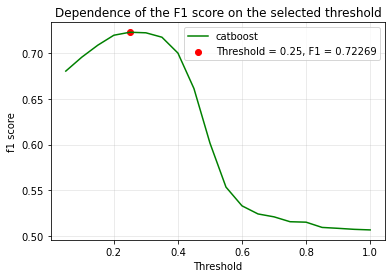

При пороге 0.25 значение F1 (macro) принимает максимальное значение в 0.72269


In [188]:
results['catboost'] = np.nan
results.loc[f_test_df_nnul.index, 'catboost'] = f_test_df_nnul['pred']

f1_draw('catboost')

Метрика получилась как минимум выше того, что вышло на бейзлайне. Что уже не может не радовать. Попробуем модель с распределением по услугам, хотя здесь она может не дать существенных различий из-за принципа работы бустинга:

In [190]:
%%time
to_drop = ['id', 'target', 'vas_id']

f_test_df_nnul['pred'] = np.nan

dedicated_model = dict()
for val in results.vas_id.value_counts().index:
    model = CatBoostClassifier(verbose=False)
    model.fit(f_train_df_nnul.loc[f_train_df_nnul.vas_id == val].drop(columns=to_drop),
              f_train_df_nnul.loc[f_train_df_nnul.vas_id == val, 'target']
              )
    dedicated_model[val] = model
    f_test_df_nnul.loc[f_test_df_nnul.vas_id == val, 'pred'] = \
        model.predict_proba(f_test_df_nnul.loc[f_test_df_nnul.vas_id == val].drop(
            columns=to_drop + ['pred']))[:, 1].copy()

Wall time: 3min 38s


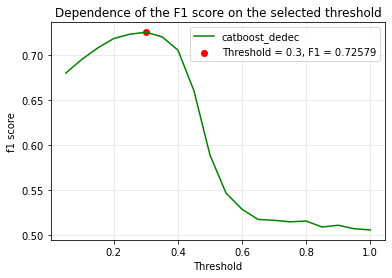

При пороге 0.3 значение F1 (macro) принимает максимальное значение в 0.72579


In [191]:
results['catboost_dedec'] = np.nan
results.loc[f_test_df_nnul.index, 'catboost_dedec'] = f_test_df_nnul['pred']

f1_draw('catboost_dedec')

Метрика хоть и несколько возросла, но не критично, как и предполагалось. Поэтому для оптимизации конечной модели предлагается использоваль `catboost` без разбиения на услуги:

In [6]:
class VAS_promotion():
    def __init__(self, seed=None, **kwargs):
        self.model = CatBoostClassifier(verbose=False, **kwargs)
        self.seed=seed
        
    def fit(self, X, target='target'):
        self.stat_vas = X.groupby('vas_id')[target].agg(['mean', 'count']).reset_index()[['vas_id', 'mean', 'count']]
        self.stat_vas.vas_id = self.stat_vas.vas_id.astype('int')
        self.stat_vas.loc[self.stat_vas.vas_id.isin([2, 5, 6]), 'mean'] = self.stat_vas.loc[self.stat_vas.vas_id.isin([2, 5, 6]), 'mean']**0.5
        
        X_nnul = X.loc[~X.isna().any(axis=1)].copy()
        X_nnul.buy_time = X_nnul.buy_time.view(dtype='int64')
        X_nnul['pred'] = np.nan

        to_drop = ['id', target]

        self.model.fit(X_nnul.drop(columns=to_drop), X_nnul[target])
        
    def predict_proba(self, X):
        
        X_nnul = X.loc[~X.isna().any(axis=1)].copy()
        
        to_drop = ['id']

        pred = self.model.predict_proba(X_nnul.drop(columns=to_drop))

        X_nnul = X_nnul.reset_index()
        X_nnul['pred'] = pred[:, 1]
        X_nnul.index = X_nnul['index']
        X_nnul.drop(columns='index', inplace=True)
        
        results = X[['buy_time', 'id', 'vas_id']].copy()
        results['vas_id'] = X['vas_id'].astype('int')
        results = results.join(self.stat_vas[['vas_id', 'mean']].set_index('vas_id'), on='vas_id', rsuffix='_r')[['buy_time', 'id', 'vas_id', 'mean']]
        results.columns = ['buy_time', 'id', 'vas_id', 'popularity']
        results['catboost'] = np.nan
        results.loc[X_nnul.index, 'catboost'] = X_nnul['pred']
        
        self.X_nnul = X_nnul.copy()
        self.results = results.copy()

        np.random.seed(self.seed)
        koeff = np.random.normal(loc=1, scale=1, size=results.popularity.shape[0])
        popular = results.popularity * koeff
        
        tmp = results.copy()
        tmp.popularity = tmp.popularity * koeff
        tmp.loc[tmp['catboost'].isna(), 'catboost'] = tmp['popularity']
        pred = tmp[['buy_time', 'id', 'vas_id', 'catboost']]

        return pred
    
    def predict(self, X, threshold=0.5):
        preds_proba = self.predict_proba(X).copy()
        preds_proba['catboost'] = preds_proba['catboost'].where(preds_proba['catboost'] < threshold, 1)
        preds_proba['catboost'] = preds_proba['catboost'].where(preds_proba['catboost'] >= threshold, 0)
        
        return preds_proba

In [13]:
merged_test_df = pd.merge_asof(test_df.sort_values('buy_time'),
                                  dd_df.sort_values('buy_time'),
                                  by='id',
                                  on='buy_time',
                                  tolerance=max_delta,
                                  direction='backward'
                                 ).sort_values('id')

In [11]:
model_vas = VAS_promotion(seed=10)
model_vas.fit(f_train_df)

In [18]:
preds = model_vas.predict(merged_test_df)
preds.head()

,buy_time,id,vas_id,catboost
44286,2019-01-13 21:00:00,55,2,0.0
63606,2019-01-20 21:00:00,64,4,0.0
44183,2019-01-13 21:00:00,151,2,0.0
63585,2019-01-20 21:00:00,274,4,0.0
44373,2019-01-13 21:00:00,274,2,0.0


После получения результатов предсказания модели можно сделать постфильтрацию данных на основе бизнес-логики.

Например, пользователям, которым ранее конкретная услуга предлагалась, далее ее уже не предлагать. Здесь потенциально может быть два варианта: пользователь принял предложение, а значит (пока он не отключил ее) предлагать больше смысла нет; а также пользователь не принял предложение, значит его что-то не устроило, поэтому также предлагать пока ее смысла нет.

In [19]:
def post_filtration(merged_train_df, merged_test_df, preds, column):
    min_index = merged_train_df.shape[0]
    
    merged = merged_train_df.drop(columns='target').append(merged_test_df)[['id', 'vas_id', 'buy_time']]
    merged.reset_index(inplace=True)
    
    index_dict = merged['index'].to_dict()
    
    grouped_id_vas = merged.sort_values('buy_time', ascending=True).groupby(['vas_id', 'id']).cumcount() + 1
    grouped_id_vas = grouped_id_vas.loc[(grouped_id_vas > 1) & (grouped_id_vas.index >= min_index)]
    
    idx = [index_dict[idx] for idx in grouped_id_vas.index]
    preds = preds.copy()
    preds.loc[idx, column] = 0
    
    
    return preds

In [20]:
preds_filtered = post_filtration(merged_train_df, merged_test_df, preds, 'catboost')

In [23]:
preds_filtered.to_csv(DATA_PATH / 'predicts.csv', index=False)

with open(DATA_PATH / 'model_vas.dill', 'wb') as f:
    dill.dump(model_vas, f)